In [1]:
# import packages here to reduce the size of code cells later

import pandas as pd
from prettypandas import PrettyPandas
import patsy

import numpy as np
import scipy.stats
import statsmodels.formula.api
import statsmodels.api as sm

from graphviz import Digraph
import seaborn as sns

import dexpy.factorial
import dexpy.alias
import dexpy.power

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import patches

from IPython.display import display, Markdown, HTML


In [2]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

# Design of Experiments in Python

Hank Anderson  
<hank@statease.com>  
https://github.com/hpanderson/dexpy-pymntos  

# Agenda

* What is Design of Experiments?
* Design an experiment with `dexpy` to improve the office coffee
* Measure the power of our experiment
* Model the taste test results using `statsmodels`
* Visualize the data with `seaborn` and `matplotlib` to find the best pot of coffee

# What is Design of Experiments (DoE)?

A systematic series of tests, in which purposeful changes are made to input factors, so that you may identify causes for significant changes in the output responses.

NIST has a [nice primer on DOE](http://www.itl.nist.gov/div898/handbook/pri/section1/pri1.htm).

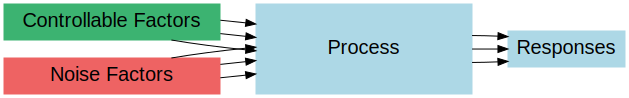

In [3]:
dot = Digraph(comment='Design of Experiments')
dot.body.extend(['rankdir=LR', 'size="10,10"'])
dot.node_attr.update(shape='rectangle', style='filled', fontsize='20', fontname="helvetica")

dot.node('X', 'Controllable Factors', color='mediumseagreen', width='3')
dot.node('Z', 'Noise Factors', color='indianred2', width='3')
dot.node('P', 'Process', color='lightblue', height='1.25', width='3')
dot.node('Y', 'Responses', color='lightblue')

dot.edges(['XP', 'ZP', 'PY'] * 3)

dot

# What Is It For?

* Screening Experiments - Determining which inputs to your system are important
* Modeling a Process - Gain a better understanding of your system
* Optimization - Find the combination of inputs that results in a better output
* Robustness - Find a combination of inputs that produces a consistent result

# DoE in Python: dexpy

* Based on Design-Expert<sup>&reg;</sup> software, a package for design and analysis of industrial experiments
* Apache2 licensed, pure python (for now), available on pypi
* Requires `numpy`, `scipy`, `pandas` and `patsy`
* Recommend `statsmodels` for analysis, `matplotlib` and `seaborn` for visualization
* Other alternatives are:
 * [pyDOE](https://github.com/tisimst/pyDOE) (not actively maintained)
 * R [???](https://cran.r-project.org/web/views/ExperimentalDesign.html)
 * [SciDOE](https://forge.scilab.org/index.php/p/scidoe/)
 * [gosset](http://neilsloane.com/gosset/)
 * Proprietary software ($$$) - [Design-Expert](https://www.statease.com), [JMP](https://www.jmp.com), [Minitab](https://www.minitab.com)

# Motivating Example: Better Office Coffee

 * Current coffee is subpar ("disgusting and unacceptable")
 * Need to answer the following questions via experimentation:
  * What coffee wt to use?
  * How much coffee to use?
  * How to grind the coffee?

# Motivating Example: Better Office Coffee

 * 5 input factors
  * lh of Coffee (2.5 to 4.0 oz.)
  * Grind size (8-10mm)
  * Brew time (3.5 to 4.5 minutes)
  * Grind Type (burr vs blade)
  * Coffee wt (light vs dark)
 * 1 response: Average overall liking by a panel of 5 office coffee addicts
  * Each taster rates the coffee from 1-9
 * Maximum of 3 taste tests a day, for liability reasons
 

In [4]:
# Layer Thickness = lh
lh_low = .16 
lh_hi = .24 

# Print Speed = ps
ps_low = 50 
ps_hi = 60 

# Infill Density = id
id_low = .25 
id_hi = .15 

# Raster Width = rw
rw_low = .4 
rw_hi = .8 

# Wall Thicknessv = wt
wt_low = 1.2 
wt_hi = .8

In [5]:
# set some variables related to the coffee data set
actual_lows = { 'lh' : lh_low, 'ps' : ps_low, 'id': id_low, 'rw': rw_low, 'wt': wt_low }
actual_highs = { 'lh' : lh_hi, 'ps' : ps_hi, 'id': id_hi, 'rw': rw_hi, 'wt': wt_hi }
units = { 'lh' : 'mm', 'ps' : 'mm/s', 'id': '%', 'rw': 'mm', 'wt': 'mm' }

# One Factor at a Time Experimentation

* Hold all inputs constant, then change one at a time
* Cannot detect interactions, e.g. grind size and lh of coffee have a synergistic relationship
* Inefficient

/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


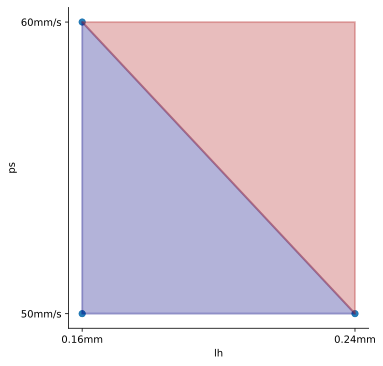

In [6]:
points = [
    [-1, -1],
    [-1, 1],
    [1, -1],
    [-1, -1],
    [-1, 1],
    [1, -1],
]
df = pd.DataFrame(points, columns=['ps', 'lh'])
fg = sns.lmplot('lh', 'ps', data=df, fit_reg=False)

p = patches.Polygon(points, color="navy", alpha=0.3, lw=2)
ax = fg.axes[0, 0]
ax.add_patch(p)
ax.set_xticks([-1, 1])
ax.set_xticklabels(get_tick_labels('lh', actual_lows, actual_highs, units))
ax.set_yticks([-1, 1])
ax.set_yticklabels(get_tick_labels('ps', actual_lows, actual_highs, units))

p = patches.Polygon([[-1, 1], [1, 1], [1, -1]], color="firebrick", alpha=0.3, lw=2)
p = ax.add_patch(p)


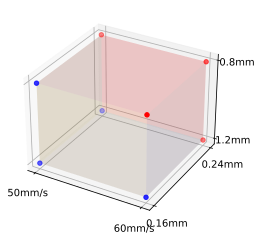

In [7]:
cube_design = dexpy.factorial.build_factorial(3, 8)

points = np.array(cube_design)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d', facecolor='w')
ax.view_init(30, -60) # rotate plot

X, Y = np.meshgrid([-1,1], [-1,1])

cube_alpha = 0.1
ax.plot_surface(X, Y, np.atleast_2d(1), alpha=cube_alpha, color="r")
ax.plot_surface(X, Y, np.atleast_2d(-1), alpha=cube_alpha)
ax.plot_surface(X, -1, Y, alpha=cube_alpha)
ax.plot_surface(X, 1, Y, alpha=cube_alpha, color="r")
ax.plot_surface(1, X, Y, alpha=cube_alpha, color="r")
ax.plot_surface(-1, X, Y, alpha=cube_alpha)
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2],
             c=["b", "b", "b", "r", "b", "r", "r", "r"])

ax.set_xticks([-1, 1])
ax.set_xticklabels(get_tick_labels('ps', actual_lows, actual_highs, units))
ax.set_yticks([-1, 1])
ax.set_yticklabels(get_tick_labels('lh', actual_lows, actual_highs, units))
ax.set_zticks([-1, 1])
ax.set_zticklabels(get_tick_labels('wt', actual_lows, actual_highs, units))

plt.show()

# Factorial Design

* Change multiple inputs at once
* Reveals interactions
* Maximizes information with minimum runs

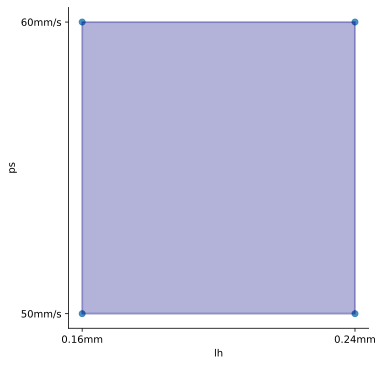

In [8]:
df = dexpy.factorial.build_factorial(2, 4)
df.columns = ['lh', 'ps']

fg = sns.lmplot('lh', 'ps', data=df, fit_reg=False)
ax = fg.axes[0, 0]
ax.set_xticks([-1, 1])
ax.set_xticklabels(get_tick_labels('lh', actual_lows, actual_highs, units))
ax.set_yticks([-1, 1])
ax.set_yticklabels(get_tick_labels('ps', actual_lows, actual_highs, units))
p = ax.add_patch(patches.Rectangle((-1, -1), 2, 2, color="navy", alpha=0.3, lw=2))

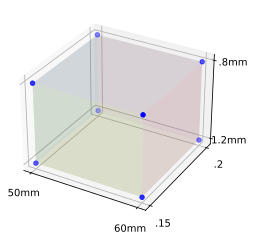

In [9]:
cube_design = dexpy.factorial.build_factorial(3, 8)

points = np.array(cube_design)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d', facecolor='w')
ax.view_init(30, -60) # rotate plot

X, Y = np.meshgrid([-1,1], [-1,1])

cube_alpha = 0.1
ax.plot_surface(X, Y, np.atleast_2d(1), alpha=cube_alpha)
ax.plot_surface(X, Y, np.atleast_2d(-1), alpha=cube_alpha)
ax.plot_surface(X, -1, Y, alpha=cube_alpha)
ax.plot_surface(X, 1, Y, alpha=cube_alpha)
ax.plot_surface(1, X, Y, alpha=cube_alpha)
ax.plot_surface(-1, X, Y, alpha=cube_alpha)
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], c="b")

ax.set_xticks([-1, 1])
ax.set_xticklabels(["50mm", "60mm"])
ax.set_yticks([-1, 1])
ax.set_yticklabels([".15", ".2"])
ax.set_zticks([-1, 1])
ax.set_zticklabels(["1.2mm", ".8mm"])

plt.show()

# Statistical Power

The probability that a design will detect an active effect.

| Effect?       | Retain H<sub>0</sub>   | Reject H<sub>0</sub>    |
| ------------- |:-----------------------| -----------------------:|
| **No**        | OK                     | Type 1 Error            |
| **Yes**       | Type II Error          | OK                      |

Power is expressed as a probability to detect an effect of size Δ, given noise σ. This is typically given as a delta to sigma ratio Δ/σ. Power is a function of the signal to noise ratio, as well as the number and layout of experiments in the design.


# Power Example
25 pots of coffee are tested with light wt, then 25 pots with dark wt.
There is a variance of 1.5 taste rating from pot to pot. If we expect a 0.5 change
in the taste rating when going from light to dark, what is the likelihood we would detect it?
(Answer: **37.86%**)

Note: this assumes that we reject H<sub>0</sub> at p <= 0.05


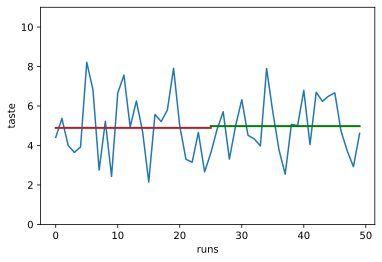

In [10]:
runs = 50
delta = 0.5
sigma = 1.5
alpha = 0.05

one_factor = pd.DataFrame([ -1, 1 ] * runs, columns=['wt'])
one_factor_power = dexpy.power.f_power('wt', one_factor, delta/sigma, alpha)

display(Markdown('''
# Power Example
{} pots of coffee are tested with light wt, then {} pots with dark wt.
There is a variance of {} taste rating from pot to pot. If we expect a {} change
in the taste rating when going from light to dark, what is the likelihood we would detect it?
(Answer: **{:.2f}%**)

Note: this assumes that we reject H<sub>0</sub> at p <= {}
'''.format(int(runs / 2), int(runs / 2), sigma, delta, one_factor_power[1]*100, alpha)
))

def plot_shift(runs, delta, sigma, annotate=False):
    """Plots two sets of random normal data, one shifted up delta units."""
    mean = 5
    low = sigma*np.random.randn(int(runs/2),1)+mean
    high = sigma*np.random.randn(int(runs/2),1)+mean+delta
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylabel("taste")
    ax.set_xlabel("runs")
    ax.set_ylim([0, 11])
    
    plt.plot(np.concatenate([low, high]))
    plt.plot([0, (runs/2)], [low.mean()] * 2, color='firebrick', lw=2)
    plt.plot([(runs/2), runs-1], [high.mean()] * 2, color='g', lw=2)
    
    p_value = scipy.stats.f_oneway(low, high).pvalue[0]
    if annotate:
        plt.annotate("p: {:.5f}".format(p_value),
                     xy=(runs / 2, (low.mean() + high.mean()) / 2), xycoords='data',
                     xytext=(.8, .9), textcoords='axes fraction',
                     bbox=dict(boxstyle="round4", fc="w"),
                     arrowprops=dict(arrowstyle='-[', linewidth=2, color='black', connectionstyle="angle3")
                     )

    plt.show()
    return [low, high]

low, high = plot_shift(runs, delta, sigma)


# Power Example - Increase Delta
What if we don't care about a taste increase of 0.5? That's not that much better
than the current coffee, after all. Instead, if we say we only care about a change
in rating above 2.0, what is the likelihood we would detect such a change?
(Answer: **99.99983%**)


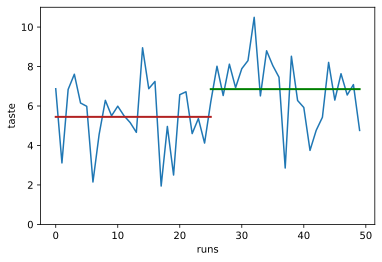

In [11]:
increased_delta = delta*4
increased_delta_power = dexpy.power.f_power('wt', one_factor, increased_delta/sigma, alpha)

display(Markdown('''
# Power Example - Increase Delta
What if we don't care about a taste increase of 0.5? That's not that much better
than the current coffee, after all. Instead, if we say we only care about a change
in rating above {}, what is the likelihood we would detect such a change?
(Answer: **{:.5f}%**)
'''.format(increased_delta, increased_delta_power[1]*100)
))

_ = plot_shift(runs, increased_delta, sigma)


# Power Example - Decrease Noise
Instead of lowering our standards for our noisy taste ratings, instead
we could bring in expert testers who have a much more accurate palate.
If we assume a decrease in noise from 1.5 to 0.75, then we can detect a
change in rating of 0.5 with 91.00% probability.


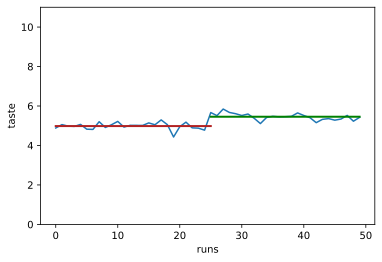

In [12]:
decreased_sigma = sigma*0.5
decreased_sigma_power = dexpy.power.f_power('wt', one_factor, delta/decreased_sigma, alpha)

display(Markdown('''
# Power Example - Decrease Noise
Instead of lowering our standards for our noisy taste ratings, instead
we could bring in expert testers who have a much more accurate palate.
If we assume a decrease in noise from {} to {}, then we can detect a
change in rating of {} with {:.2f}% probability.
'''.format(sigma, decreased_sigma, delta, decreased_sigma_power[1]*100)
))

_ = plot_shift(runs, delta, sigma*0.1)


# Power Example - Increase Runs
If expert testers are too expensive, and we are unwilling to compromise
our standards, then the only remaining option is to create a more powerful
design. In this toy example, there isn't much we can do, since it's
just one factor. Increasing the runs from 50 to 200 gives a power of
91.39%. This may be a more acceptable success rate than the original power
of 37.86%, however... that is a lot of coffee to drink.

For more complicated designs changing the structure of the design
can also increase power.


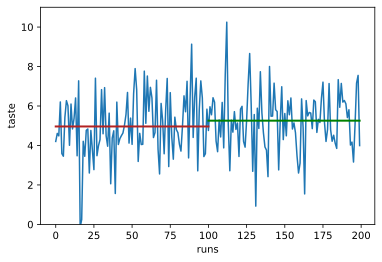

In [13]:
increased_runs = runs * 4
one_factor = pd.DataFrame([ -1, 1 ] * increased_runs, columns=['wt'])
increased_runs_power = dexpy.power.f_power('wt', one_factor, delta/sigma, alpha)

display(Markdown('''
# Power Example - Increase Runs
If expert testers are too expensive, and we are unwilling to compromise
our standards, then the only remaining option is to create a more powerful
design. In this toy example, there isn't much we can do, since it's
just one factor. Increasing the runs from {} to {} gives a power of
{:.2f}%. This may be a more acceptable success rate than the original power
of {:.2f}%, however... that is a lot of coffee to drink.

For more complicated designs changing the structure of the design
can also increase power.
'''.format(runs, increased_runs, increased_runs_power[1]*100, one_factor_power[1]*100)
))
_ = plot_shift(increased_runs, delta, sigma)

# Calculating Power with dexpy

https://statease.github.io/dexpy/evaluation.html#statistical-power

In [14]:
help(dexpy.power.f_power)

Help on function f_power in module dexpy.power:

f_power(model, design, effect_size, alpha)
    Calculates the power of an F test.
    
    This calculates the probability that the F-statistic is above its critical
    value (alpha) given an effect of some size.
    
    :param model: A patsy formula for which to calculate power.
    :type model: patsy.formula
    :param design: A pandas.DataFrame representing a design.
    :type design: pandas.DataFrame
    :param effect_size: The size of the effect that the test should be able to detect (also called a signal to noise
        ratio).
    :type effect_size: float
    :param alpha: The critical value that we want the test to be above.
    :type alpha: float between 0 and 1
    :returns: A list of percentage probabilities that an F-test could detect an effect of the given size at the given
        alpha value for a particular column.
    
    Usage:
      >>> design = dexpy.factorial.build_factorial(4, 8)
      >>> print(dexpy.power.f_po

In [15]:
base_point = [-1, -1, -1, -1, -1]
ofat_points = [base_point]

for i in range(0, 5):
    new_point = base_point[:]
    new_point[i] = 1
    ofat_points.append(new_point)

sn = 2.0
alpha = 0.05

ofat_df = pd.DataFrame(ofat_points*5, columns=['lh', 'ps', 'id', 'rw', 'wt'])
model = ' + '.join(ofat_df.columns)
ofat_power = dexpy.power.f_power('+'.join(ofat_df.columns), ofat_df, sn, alpha)
ofat_power.pop(0) # remove intercept
ofat_power = ['{0:.2f}%'.format(i*100) for i in ofat_power] # convert to %
ofat_power = pd.DataFrame(ofat_power, columns=['Power'], index=ofat_df.columns)

display(Markdown('''
# Calculating Power with dexpy: OFAT
* {} total runs, with a signal to noise ratio of 2.
* Model: `{}`
'''.format(len(ofat_df), model)))

display(PrettyPandas(ofat_power))


# Calculating Power with dexpy: OFAT
* 30 total runs, with a signal to noise ratio of 2.
* Model: `lh + ps + id + rw + wt`


,Power
lh,85.85%
ps,85.85%
id,85.85%
rw,85.85%
wt,85.85%


In [16]:
full_design = dexpy.factorial.build_factorial(5, 2**5)
full_design.columns = ['lh', 'ps', 'id', 'rw', 'wt']
factorial_power = dexpy.power.f_power(model, full_design, sn, alpha)
factorial_power.pop(0)
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power] # convert to %
factorial_power = pd.DataFrame(factorial_power, columns=['Power'], index=full_design.columns)

display(Markdown('''
# Calculating Power with dexpy: Factorial
* {} total runs, with a signal to noise ratio of 2.
* Model (`patsy` for: `{}`
'''.format(len(full_design), model)))
display(PrettyPandas(factorial_power))


# Calculating Power with dexpy: Factorial
* 32 total runs, with a signal to noise ratio of 2.
* Model (`patsy` for: `lh + ps + id + rw + wt`


,Power
lh,99.97%
ps,99.97%
id,99.97%
rw,99.97%
wt,99.97%


# Fractional Factorials

* Coffee experiment is 2<sup>5</sup> runs (32)
* We want to add 4 center point runs to check for curvature
* Total runs = 36, 3 per day if all testers are in the office
* Estimate experiment will take a month

# Fractional Factorials
* Power for the experiment is > 99%
* Full factorial is overkill
* Instead run 2<sup>5-1</sup> experiments, a "half fraction"


# Fractional Factorials in dexpy

https://statease.github.io/dexpy/design-build.html#module-dexpy.factorial

In [17]:
help(dexpy.factorial.build_factorial)

Help on function build_factorial in module dexpy.factorial:

build_factorial(factor_count, run_count)
    Builds a regular two-level design based on a number of factors and runs.
    
    Full two-level factorial designs may be run for up to 9 factors. These
    designs permit estimation of all main effects and all interaction effects.
    If the number of runs requested is a 2^factor_count, the design will be a
    full factorial.
    
    If the number of runs is less than 2^factor_count (it still must be a power
    of two) a fractional design will be created. Not all combinations of runs
    and factor counts will result in a design. Use the
    :ref:`alias list<alias-list>` method to see what terms are estimable in
    the resulting design.
    
    :param factor_count: The number of factors to build for.
    :type factor_count: int
    :param run_count: The number of runs in the resulting design. Must be a power of 2.
    :type run_count: int
    :returns: A pandas.DataFrame obje

In [18]:


# cr6_print_history = dexpy.factorial.build_factorial(5, 2**(5-1))
# cr6_print_history.columns = ['lh', 'ps', 'id', 'rw', 'wt']
center_points = [
]

columns = ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'cost', 'time', 'quality', 'comment']

cr6_print_history = pd.read_csv('file:///Users/wilsonm/Dropbox%20(APSU%20GIS)/Projects%20(DB)/Dissertation/3DP_Experiments/Data/cr6-doe-schedule.csv', skiprows=1, names=columns)

#cr6_print_history = cr6_print_history.append(pd.DataFrame(center_points * 2, columns=cr6_print_history.columns))
cr6_print_history.index = np.arange(0, len(cr6_print_history))

display(Markdown("## 2<sup>(5-1)</sup> Factorial Design"))
display(PrettyPandas(cr6_print_history))

actual_design = coded_to_actual(cr6_print_history, actual_lows, actual_highs)
cr6_print_actual = actual_design
display(Markdown("Actual ## 2<sup>(5-1)</sup> Factorial Design"))
display(PrettyPandas(actual_design))

## 2<sup>(5-1)</sup> Factorial Design

,trial,lh,ps,id,rw,wt,cost,time,quality,comment
0,1,-1,-1,-1,-1,1,0.510000,8746.000000,1,nan
1,2,1,-1,-1,-1,-1,0.504000,17946.000000,1,nan
2,3,-1,1,-1,-1,-1,0.540000,14449.600000,1,nan
3,4,1,1,-1,-1,1,0.510000,10178.600000,1,nan
4,5,-1,-1,1,-1,-1,0.540000,14987.200000,1,nan
5,6,1,-1,1,-1,1,0.500000,10362.000000,1,nan
6,7,-1,1,1,-1,1,0.500000,16635.200000,1,nan
7,8,1,1,1,-1,-1,0.540000,8838.600000,1,nan
8,9,-1,-1,-1,1,-1,0.540000,15108.200000,1,nan
9,10,1,-1,-1,1,1,0.560000,10623.400000,1,nan


Actual ## 2<sup>(5-1)</sup> Factorial Design

,trial,lh,ps,id,rw,wt,cost,time,quality,comment
0,1,0.160000,50.000000,0.250000,0.400000,0.800000,0.510000,8746.000000,1,nan
1,2,0.240000,50.000000,0.250000,0.400000,1.200000,0.504000,17946.000000,1,nan
2,3,0.160000,60.000000,0.250000,0.400000,1.200000,0.540000,14449.600000,1,nan
3,4,0.240000,60.000000,0.250000,0.400000,0.800000,0.510000,10178.600000,1,nan
4,5,0.160000,50.000000,0.150000,0.400000,1.200000,0.540000,14987.200000,1,nan
5,6,0.240000,50.000000,0.150000,0.400000,0.800000,0.500000,10362.000000,1,nan
6,7,0.160000,60.000000,0.150000,0.400000,0.800000,0.500000,16635.200000,1,nan
7,8,0.240000,60.000000,0.150000,0.400000,1.200000,0.540000,8838.600000,1,nan
8,9,0.160000,50.000000,0.250000,0.800000,1.200000,0.540000,15108.200000,1,nan
9,10,0.240000,50.000000,0.250000,0.800000,0.800000,0.560000,10623.400000,1,nan


In [19]:
# Transform DOE Schedule CSV dataframe to only include parameters

myDoE = cr6_print_history[['lh', 'ps', 'id', 'rw', 'wt']]
myDoE2 = cr6_print_actual[['lh', 'ps', 'id', 'rw', 'wt']]

In [20]:
model = ' + '.join(myDoE.columns)
factorial_power = dexpy.power.f_power(model, myDoE, sn, alpha)
factorial_power.pop(0)
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power] # convert to %
factorial_power = pd.DataFrame(factorial_power, columns=['Power'], index=myDoE.columns)

display(Markdown('''
## 2<sup>(5-1)</sup> Factorial Power
* Power for {} total runs
* Signal to noise ratio of 2
* Model: `{}`
'''.format(len(myDoE), model)))
display(PrettyPandas(factorial_power))


## 2<sup>(5-1)</sup> Factorial Power
* Power for 18 total runs
* Signal to noise ratio of 2
* Model: `lh + ps + id + rw + wt`


,Power
lh,95.58%
ps,95.58%
id,95.58%
rw,95.58%
wt,95.58%


In [21]:
help(dexpy.power.f_power)

Help on function f_power in module dexpy.power:

f_power(model, design, effect_size, alpha)
    Calculates the power of an F test.
    
    This calculates the probability that the F-statistic is above its critical
    value (alpha) given an effect of some size.
    
    :param model: A patsy formula for which to calculate power.
    :type model: patsy.formula
    :param design: A pandas.DataFrame representing a design.
    :type design: pandas.DataFrame
    :param effect_size: The size of the effect that the test should be able to detect (also called a signal to noise
        ratio).
    :type effect_size: float
    :param alpha: The critical value that we want the test to be above.
    :type alpha: float between 0 and 1
    :returns: A list of percentage probabilities that an F-test could detect an effect of the given size at the given
        alpha value for a particular column.
    
    Usage:
      >>> design = dexpy.factorial.build_factorial(4, 8)
      >>> print(dexpy.power.f_po

In [22]:
twofi_model = "(" + '+'.join(myDoE.columns) + ")**2"
desc = patsy.ModelDesc.from_formula(twofi_model)
factorial_power = dexpy.power.f_power(twofi_model, myDoE, sn, alpha)


factorial_power.pop(0)
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power] # convert to %
factorial_power = pd.DataFrame(factorial_power, columns=['Power'], index=desc.describe().strip("~ ").split(" + "))

display(Markdown('''
## 2<sup>(5-1)</sup> Factorial Power
* Power for {} total runs
* Signal to noise ratio of 2
* Model: `{}`
'''.format(len(myDoE), twofi_model)))
display(Markdown("## Power for {} total runs, with a signal to noise ratio of 2.".format(len(myDoE))))
display(PrettyPandas(factorial_power))


## 2<sup>(5-1)</sup> Factorial Power
* Power for 18 total runs
* Signal to noise ratio of 2
* Model: `(lh+ps+id+rw+wt)**2`


## Power for 18 total runs, with a signal to noise ratio of 2.

,Power
lh,56.45%
ps,56.45%
id,56.45%
rw,56.45%
wt,56.45%
lh:ps,56.45%
lh:id,56.45%
lh:rw,56.45%
lh:wt,56.45%
ps:id,56.45%


In [23]:
display(Markdown('''
# Aliasing

When you don't run all combinations of inputs, you lose the ability to estimate terms
For example, if you have three inputs the full model matrix looks like this:
'''))

three_factor_design = dexpy.factorial.build_factorial(3, 8)
X = patsy.dmatrix("(" + " + ".join(three_factor_design.columns) + ")**3", three_factor_design, return_type='dataframe')
display(PrettyPandas(X))



# Aliasing

When you don't run all combinations of inputs, you lose the ability to estimate terms
For example, if you have three inputs the full model matrix looks like this:


,Intercept,X1,X2,X3,X1:X2,X1:X3,X2:X3,X1:X2:X3
0,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000
1,1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000
2,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000
3,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
4,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
5,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000
6,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
display(Markdown('''
## Aliasing

If we remove half the runs, so that the design is 2<sup>3-1</sup>:
'''))

X.loc[[0,3,5,6]] = ''
display(PrettyPandas(X))
      
display(Markdown('''
You can see that A*B*C never changes. In addition, A = BC and B = AC.
When a term is a linear combination of another term that is called an **alias**. Aliased terms are unestimable.
'''))


## Aliasing

If we remove half the runs, so that the design is 2<sup>3-1</sup>:


,Intercept,X1,X2,X3,X1:X2,X1:X3,X2:X3,X1:X2:X3
0,,,,,,,,
1,1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000
2,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000
3,,,,,,,,
4,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
5,,,,,,,,
6,,,,,,,,
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



You can see that A*B*C never changes. In addition, A = BC and B = AC.
When a term is a linear combination of another term that is called an **alias**. Aliased terms are unestimable.


## Calculating Aliases in dexpy

dexpy can calculate the terms that are linear combinations of other terms.

https://statease.github.io/dexpy/evaluation.html#alias-list

In [25]:
help(dexpy.alias.alias_list)

Help on function alias_list in module dexpy.alias:

alias_list(model, design)
    Returns a human-readable list of dependent model columns.
    
    This is done by solving AX=B, where X is the full rank model matrix,
    and B is all of the columns of the model matrix. The result is a matrix
    of coefficients which represent to what degree a given column is
    collinear with another column.
    
    Usage:
      >>> design = dexpy.factorial.build_factorial(4, 8)
      >>> aliases, alias_coefs = dexpy.alias.alias_list("(A+B+C+D)**2)", design)
      >>> print(aliases)
      ['A:B = C:D', 'A:C = B:D', 'A:D = B:C']



### Cost Calculating Aliases in dexpy

In [26]:
cr6_alias = cr6_print_history[['lh', 'ps', 'id', 'rw', 'wt']]

In [27]:
display(Markdown('''
## Calculating Aliases in dexpy

Here is what that alias list looks like for our 3DP Experiment:
'''))
    
full_model = "(" + '+'.join(cr6_alias.columns) + ")**3"
aliases, _ = dexpy.alias.alias_list(full_model, cr6_alias)
for a in aliases:
    print(a)
    
display(Markdown('''
As you can see, we lose the ability to estimate some three factor interactions separately from the two factor interactions.
This is not a cause for great concern as the three factor interactions are rare in practice.
'''))


## Calculating Aliases in dexpy

Here is what that alias list looks like for our 3DP Experiment:


lh:ps = id:rw:wt
lh:id = ps:rw:wt
lh:rw = ps:id:wt
lh:wt = ps:id:rw
ps:id = lh:rw:wt
ps:rw = lh:id:wt
ps:wt = lh:id:rw
id:rw = lh:ps:wt
id:wt = lh:ps:rw
rw:wt = lh:ps:id


/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/dexpy/alias.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alias_coefs, _, _, _ = np.linalg.lstsq(unaliased, model_matrix)



As you can see, we lose the ability to estimate some three factor interactions separately from the two factor interactions.
This is not a cause for great concern as the three factor interactions are rare in practice.


# Analysis

* [statsmodels](http://statsmodels.sourceforge.net/) has lots of routines for modeling data
* We will use [Ordinary Least Squares (OLS)](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html) to fit
* `statsmodels` typically takes `numpy` arrays for X and y data
* It also has a "formulas" api that accepts a `patsy` formula

## Cost Analysis

In [28]:
cr6_time_analysis = cr6_print_history[['lh', 'ps', 'id', 'rw', 'wt', 'time']]
cr6_time_analysis2 = cr6_print_actual[['lh', 'ps', 'id', 'rw', 'wt', 'time']]
display(cr6_time_analysis2)

,lh,ps,id,rw,wt,time
0,0.16,50.0,0.25,0.4,0.8,8746.00
1,0.24,50.0,0.25,0.4,1.2,17946.00
2,0.16,60.0,0.25,0.4,1.2,14449.60
3,0.24,60.0,0.25,0.4,0.8,10178.60
4,0.16,50.0,0.15,0.4,1.2,14987.20
5,0.24,50.0,0.15,0.4,0.8,10362.00
6,0.16,60.0,0.15,0.4,0.8,16635.20
7,0.24,60.0,0.15,0.4,1.2,8838.60
8,0.16,50.0,0.25,0.8,1.2,15108.20
9,0.24,50.0,0.25,0.8,0.8,10623.40


In [29]:
y_time = cr6_time_analysis['time']
X = cr6_time_analysis[['lh', 'ps', 'id', 'rw', 'wt']]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
cost_results = sm.OLS(y_time, X).fit()
cost_results.summary()

print(cost_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     1.480
Date:                Wed, 16 Jun 2021   Prob (F-statistic):              0.267
Time:                        14:17:12   Log-Likelihood:                -166.27
No. Observations:                  18   AIC:                             344.5
Df Residuals:                      12   BIC:                             349.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.265e+04    717.641     17.623      0.0

/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


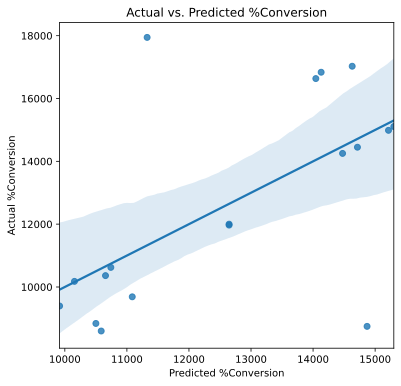

In [30]:
PlotWidth = 6
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=cost_results.predict(X), y=y_time)
plt.xlabel('Predicted %Conversion')
plt.ylabel('Actual %Conversion')
plt.title('Actual vs. Predicted %Conversion')
plt.show()

In [31]:
display(cr6_time_analysis)

,lh,ps,id,rw,wt,time
0,-1,-1,-1,-1,1,8746.00
1,1,-1,-1,-1,-1,17946.00
2,-1,1,-1,-1,-1,14449.60
3,1,1,-1,-1,1,10178.60
4,-1,-1,1,-1,-1,14987.20
5,1,-1,1,-1,1,10362.00
6,-1,1,1,-1,1,16635.20
7,1,1,1,-1,-1,8838.60
8,-1,-1,-1,1,-1,15108.20
9,1,-1,-1,1,1,10623.40


In [32]:
# Working Models
# quantreg
# poisson
# 

lm = statsmodels.formula.api.ols("time ~(lh + ps + id + rw + wt)**2", data=cr6_time_analysis).fit()
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     24.19
Date:                Wed, 16 Jun 2021   Prob (F-statistic):             0.0404
Time:                        14:17:12   Log-Likelihood:                -123.74
No. Observations:                  18   AIC:                             279.5
Df Residuals:                       2   BIC:                             293.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.265e+04    165.472     76.428      0.0

/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [33]:
reduced_model = "lh + ps + id + rw + wt + lh:wt + ps:id + ps:rw"
lm = statsmodels.formula.api.ols("time ~" + reduced_model, data=cr6_time_analysis).fit()
print(lm.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.151    
Dependent Variable: time             AIC:                350.2702  
Date:               2021-06-16 14:17 BIC:                358.2835  
No. Observations:   18               Log-Likelihood:     -166.14   
Df Model:           8                F-statistic:        0.7216    
Df Residuals:       9                Prob (F-statistic): 0.672     
R-squared:          0.391            Scale:              1.2173e+07
-------------------------------------------------------------------
             Coef.    Std.Err.    t    P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
Intercept  12646.7306 822.3581 15.3786 0.0000 10786.4273 14507.0338
lh         -2025.8969 872.2425 -2.3226 0.0453 -3999.0465   -52.7473
ps          -331.4781 872.2425 -0.3800 0.7127 -2304.6277  1641.6715
id           -81.3969 872.2425 -0.0933 0.9277 -2054.5465  1891.752

/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Visualization

* [seaborn](http://seaborn.pydata.org/) is built on top of `matplotlib` and adds support for `pandas` dataframes 
* Can build a plot using `seaborn`, then manipulate it with `matplotlib`
* Default themes look a lot nicer than what you get from `matplotlib` out of the box

In [ ]:
display(Markdown('''
If we take the experiment data from the design and use our new model to fit that data, then plot it against
the observed values we can get an idea for how well our model predicts. Points above the 45 degree line are
overpredicting for that combination of inputs. Points below the line predict a lower taste rating than
we actually measured during the experiment.'''))

actual_predicted = pd.DataFrame({ 'actual': cr6_print_history['time'],
                                  'predicted': lm.fittedvalues
                                }, index=np.arange(len(cr6_time_analysis['time'])))
fg = sns.FacetGrid(actual_predicted, height=5)
fg.map(plt.scatter, 'actual', 'predicted')
ax = fg.axes[0, 0]
ax.plot([0, 20000], [0, 20000], color='g', lw=2)
ax.set_xticks(np.arange(0, 1.5))
ax.set_xlim([0, 1.])
ax.set_yticks(np.arange(0, 20000))
ax.set_title('Actual vs Predicted')
_ = ax.set_ylim([0, 20000])


Plotting the prediction for two factors at once shows how they interact with each other.
In this graph you can see that at the low brew time the larger grind size results in
a poor taste rating, likely because the coffee is too weak.

/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


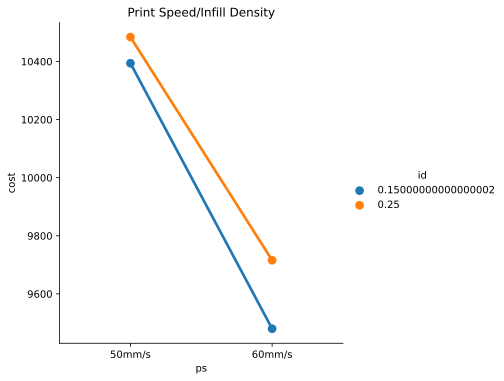

In [35]:
display(Markdown('''
Plotting the prediction for two factors at once shows how they interact with each other.
In this graph you can see that at the low brew time the larger grind size results in
a poor taste rating, likely because the coffee is too weak.'''))

pred_points = pd.DataFrame(1, columns = cr6_time_analysis.columns, index=np.arange(4))
pred_points.loc[1,'ps'] = -1
pred_points.loc[3,'ps'] = -1
pred_points.loc[2,'id'] = -1
pred_points.loc[3,'id'] = -1
pred_points['cost'] = lm.predict(pred_points)
pred_points = coded_to_actual(pred_points, actual_lows, actual_highs)

fg = sns.factorplot('ps', 'cost', hue='id', kind='point', data=pred_points)
ax = fg.axes[0, 0]
ax.set_xticklabels(get_tick_labels('ps', actual_lows, actual_highs, units))
_ = ax.set_title('Print Speed/Infill Density')

In [36]:
display(Markdown('''
This graph contains the prediction with the highest taste rating, 7.72.
However, if you look at the dark bean line there is a point where we can get
a rating of 6.93 with 2.5oz of grounds.
'''))

pred_points = pd.DataFrame(1, columns = cr6_time_analysis.columns, index=np.arange(4))
pred_points.loc[1,'lh'] = -1
pred_points.loc[3,'lh'] = -1
pred_points.loc[2,'wt'] = -1
pred_points.loc[3,'wt'] = -1
pred_points['cost'] = lm.predict(pred_points)
pred_points = coded_to_actual(pred_points, actual_lows, actual_highs)

fg = sns.factorplot('lh', 'cost', hue='wt', kind='point', palette={'dark': 'maroon', 'light': 'peru'}, data=pred_points)
ax = fg.axes[0, 0]
ax.set_xticklabels(get_tick_labels('lh', actual_lows, actual_highs, units))
ax.set_title('lh/wt Interaction')
plt.show()

display(PrettyPandas(pred_points))
display(Markdown('''That savings of 1.5oz per pot would create a nice surplus in the coffee budget at the end of the year.'''))


This graph contains the prediction with the highest taste rating, 7.72.
However, if you look at the dark bean line there is a point where we can get
a rating of 6.93 with 2.5oz of grounds.


/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/anaconda3/envs/Dissertation/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KeyError: 0.8

![coffeemaker](img/coffee_maker.jpg)

# The End

* We were able to build and execute an experiment in Python that resulted in a better tasting (and cheaper!) coffee.
* These slides can be found at https://hpanderson.github.io/dexpy-pymntos
* The jupyter notebook they are based on can be found on my github: https://github.com/hpanderson/dexpy-pymntos
* You can reach me at: <hank@statease.com>
* The `dexpy` docs are at: https://statease.github.io/dexpy/
* `dexpy` is only at version 0.1, we plan on greatly expanding the design and analysis capabilities
 